# Inferring GALAH-Style Optical Spectra from APOGEE NIR Stellar Spectra

## Background
We are in the age of massive spectroscopic surveys.  Existing spectroscopic surveys such as LAMOST, APOGEE, GALAH, and Gaia-ESO, as well as numerous upcoming surveys such as 4MOST, WEAVE, and MOONS were explicitly designed to unravel the story of our Milky Way using stellar chemistry.  High-resolution surveys in particular are ideal for studying a plethora of elemental abundances measurable in stars.  APOGEE is arguably a gold-standard survey for measuring elemental abundances of Milky Way stars.  The instrument and survey design of APOGEE produces data with high resolution, high signal to noise, and high precision in reported abundances.  However, if APOGEE truly did do everything well, we would have no need for the other surveys.  One downside of APOGEE is that due to its NIR wavelength range, it lacks access to strong and well-understood lines of elements heavier than Fe (with a few exceptions).  These elements, colloquially called "heavy elements" but technically called "neutron-capture elements," carry unique and important information that the lighter elements APOGEE do not carry.  The heavy elements have been found to carry unique information about stellar age, Galactic star formation history, the IMF, and stellar birth radius that is distinct from the information carried by the lighter elements.  Thus, it is important to study them.  APOGEE likely does carry more information about the heavy elements than what is being utilized, but we simply don't know where to look (e.g., missing atomic data, so we don't know which lines belong to what element or how their intensity scales with composition) and/or we struggle to measure them (the known lines are very weak).

Optical surveys like GALAH, on the other hand, have access to strong and well-studied lines of these elements.  The issue with optical surveys is that they tend to have lower SNR data, meaning that abundance precision and accuracy can suffer.  In this project, we will combine APOGEE and GALAH to seek to expand the chemical information that we can get out of APOGEE data.  In doing so, we will also explore the information content of two very different spectral regimes and see what information (if any) is unique to each wavelength regime.





## Science Goals
1. Expand the heavy element information we can extract from APOGEE spectra
2. More broadly, understand the information content of two different spectral regimes, the optical and the NIR, and see if there is overlap.

## Method
1.  Train an algorithm on stars that were sampled by both GALAH and APOGEE.  This algorithm will take APOGEE spectra as input and return GALAH-style spectra as output.
2. Analyze the output.  What lines are well-reproduced in GALAH, and which ones are missing?
3. Apply to APOGEE stars without GALAH spectra.
4. Identify and measure abundances of heavy elements (using some method) directly from the output GALAH-like spectra to assess the heavy-element compositions of the input APOGEE spectra.

## Deliverables
1. GALAH-like spectra for all APOGEE stars in the training set that also have GALAH spectra.
2. GALAH-like spectra for all APOGEE stars without GALAH spectra.
3. Measure abundances of lines of interest directly in the generated GALAH-like spectra to get new info from the APOGEE spectra.

## This notebook
Below you will find how to load in and prepare the data.  The data lives here: https://utexas.box.com/s/2jcw4lkz8tlttbhd97lpzaxlcn4buanx.  We will start by attempting to generate a tiny portion of the GALAH spectrum instead of the whole thing.

<table><tr>
<td> 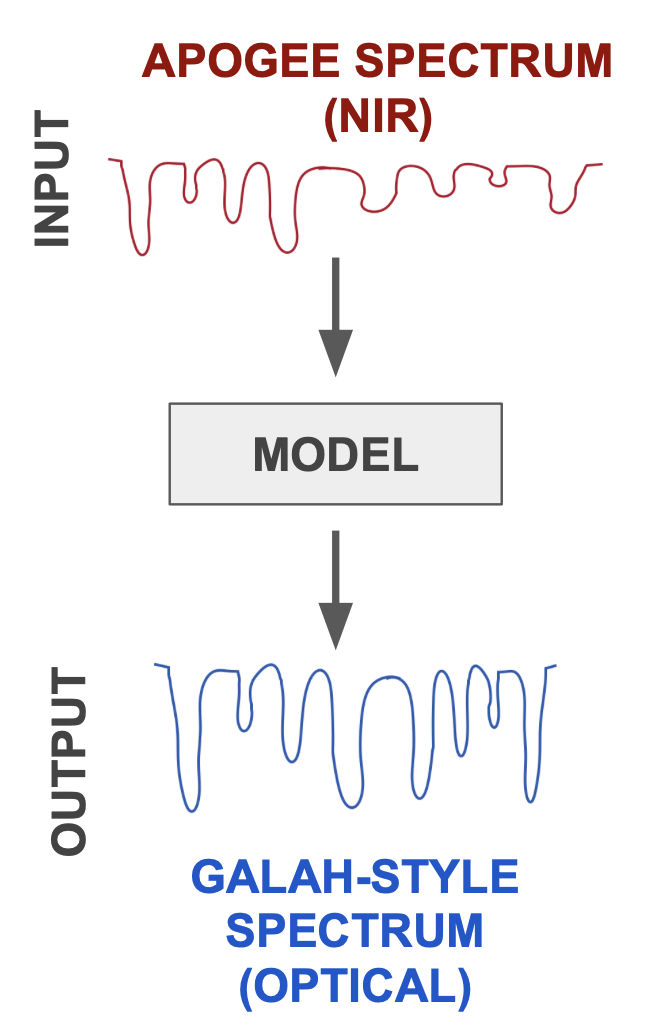 </td>
<td> <img src="" style="width: 250px;"/> </td>
</tr></table>

In [1]:
#import your functions
from astropy.table import Table, join, vstack, hstack, unique
import numpy as np
import os
import glob
import sys
from astropy.io import fits
import matplotlib.pyplot as plt

Load in your shared wavelength grids for both surveys.  All spectra within the same survey have the same wavelength array.  This is not automatic but instead was done during pre-processing via interpolation.

In [2]:
#load in shared wavelength grid for galah data
galah_wave_grid = np.concatenate([np.arange(4720, 4900, .046), np.arange(5645, 5874, .055), 
                            np.arange(6475,6730, .063)])

#load in shared wavelength grid for apogee data
apogee_wavegrid = np.linspace(15110, 16990, 8000)

Load in your crossmatch between APOGEE and GALAH.  This is a data table containing both APOGEE and GALAH-reported information for all GIANT (logg < 3.8) stars that exist in both surveys.  I am currently omitting main-sequence stars.

In [3]:
apogee_galah_join = Table.read("/Users/catherinemanea/Documents/chemical_doppelgangers/notebook/apogee_galah_join.fits", format='fits')

Check out the crossmatched table between APOGEE and GALAH.  16959 giant stars shared by both surveys.

In [4]:
apogee_galah_join


FILE,APOGEE_ID,TARGET_ID,APSTAR_ID,ASPCAP_ID,TELESCOPE,LOCATION_ID,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,TARG_PMRA,TARG_PMDEC,TARG_PM_SRC,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,APOGEE2_TARGET4,TARGFLAGS,SURVEY,PROGRAMNAME,NVISITS,SNR,SNREV,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CHI2,RV_CCFWHM,RV_AUTOFWHM,RV_FLAG,N_COMPONENTS,MEANFIB,SIGFIB,MIN_H,MAX_H,MIN_JK,MAX_JK,GAIAEDR3_SOURCE_ID,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PHOT_G_MEAN_MAG,GAIAEDR3_PHOT_BP_MEAN_MAG,GAIAEDR3_PHOT_RP_MEAN_MAG,GAIAEDR3_DR2_RADIAL_VELOCITY,GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR,GAIAEDR3_R_MED_GEO,GAIAEDR3_R_LO_GEO,GAIAEDR3_R_HI_GEO,GAIAEDR3_R_MED_PHOTOGEO,GAIAEDR3_R_LO_PHOTOGEO,GAIAEDR3_R_HI_PHOTOGEO,ASPCAP_GRID,FPARAM_GRID,CHI2_GRID,FPARAM,FPARAM_COV,ASPCAP_CHI2,PARAM,PARAM_COV,PARAMFLAG,ASPCAPFLAG,ASPCAPFLAGS,FRAC_BADPIX,FRAC_LOWSNR,FRAC_SIGSKY,FELEM,FELEM_ERR,X_H,X_H_ERR,X_M,X_M_ERR,ELEM_CHI2,ELEMFRAC,ELEMFLAG,EXTRATARG,MEMBERFLAG,MEMBER,X_H_SPEC,X_M_SPEC,TEFF,TEFF_ERR,LOGG,LOGG_ERR,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,VMICRO,VMACRO,VSINI,TEFF_SPEC,LOGG_SPEC,C_FE,C_FE_SPEC,C_FE_ERR,C_FE_FLAG,CI_FE,CI_FE_SPEC,CI_FE_ERR,CI_FE_FLAG,N_FE,N_FE_SPEC,N_FE_ERR,N_FE_FLAG,O_FE,O_FE_SPEC,O_FE_ERR,O_FE_FLAG,NA_FE,NA_FE_SPEC,NA_FE_ERR,NA_FE_FLAG,MG_FE,MG_FE_SPEC,MG_FE_ERR,MG_FE_FLAG,AL_FE,AL_FE_SPEC,AL_FE_ERR,AL_FE_FLAG,SI_FE,SI_FE_SPEC,SI_FE_ERR,SI_FE_FLAG,P_FE,P_FE_SPEC,P_FE_ERR,P_FE_FLAG,S_FE,S_FE_SPEC,S_FE_ERR,S_FE_FLAG,K_FE,K_FE_SPEC,K_FE_ERR,K_FE_FLAG,CA_FE,CA_FE_SPEC,CA_FE_ERR,CA_FE_FLAG,TI_FE,TI_FE_SPEC,TI_FE_ERR,TI_FE_FLAG,TIII_FE,TIII_FE_SPEC,TIII_FE_ERR,TIII_FE_FLAG,V_FE,V_FE_SPEC,V_FE_ERR,V_FE_FLAG,CR_FE,CR_FE_SPEC,CR_FE_ERR,CR_FE_FLAG,MN_FE,MN_FE_SPEC,MN_FE_ERR,MN_FE_FLAG,FE_H,FE_H_SPEC,FE_H_ERR,FE_H_FLAG,CO_FE,CO_FE_SPEC,CO_FE_ERR,CO_FE_FLAG,NI_FE,NI_FE_SPEC,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,YB_FE,YB_FE_SPEC,YB_FE_ERR,YB_FE_FLAG,VISIT_PK,star_id,sobject_id,dr2_source_id,dr3_source_id,survey_name,field_id,flag_repeat,wg4_field,wg4_pipeline,flag_sp,teff,e_teff,irfm_teff,irfm_ebv,irfm_ebv_ref,logg,e_logg,fe_h,e_fe_h,flag_fe_h,fe_h_atmo,vmic,vbroad,e_vbroad,chi2_sp,alpha_fe,e_alpha_fe,nr_alpha_fe,flag_alpha_fe,flux_A_Fe,chi_A_Fe,Li_fe,e_Li_fe,nr_Li_fe,flag_Li_fe,C_fe,e_C_fe,nr_C_fe,flag_C_fe,O_fe,e_O_fe,nr_O_fe,flag_O_fe,Na_fe,e_Na_fe,nr_Na_fe,flag_Na_fe,Mg_fe,e_Mg_fe,nr_Mg_fe,flag_Mg_fe,Al_fe,e_Al_fe,nr_Al_fe,flag_Al_fe,Si_fe,e_Si_fe,nr_Si_fe,flag_Si_fe,K_fe,e_K_fe,nr_K_fe,flag_K_fe,Ca_fe,e_Ca_fe,nr_Ca_fe,flag_Ca_fe,Sc_fe,e_Sc_fe,nr_Sc_fe,flag_Sc_fe,Sc2_fe,e_Sc2_fe,nr_Sc2_fe,flag_Sc2_fe,Ti_fe,e_Ti_fe,nr_Ti_fe,flag_Ti_fe,Ti2_fe,e_Ti2_fe,nr_Ti2_fe,flag_Ti2_fe,V_fe,e_V_fe,nr_V_fe,flag_V_fe,Cr_fe,e_Cr_fe,nr_Cr_fe,flag_Cr_fe,Cr2_fe,e_Cr2_fe,nr_Cr2_fe,flag_Cr2_fe,Mn_fe,e_Mn_fe,nr_Mn_fe,flag_Mn_fe,Co_fe,e_Co_fe,nr_Co_fe,flag_Co_fe,Ni_fe,e_Ni_fe,nr_Ni_fe,flag_Ni_fe,Cu_fe,e_Cu_fe,nr_Cu_fe,flag_Cu_fe,Zn_fe,e_Zn_fe,nr_Zn_fe,flag_Zn_fe,Rb_fe,e_Rb_fe,nr_Rb_fe,flag_Rb_fe,Sr_fe,e_Sr_fe,nr_Sr_fe,flag_Sr_fe,Y_fe,e_Y_fe,nr_Y_fe,flag_Y_fe,Zr_fe,e_Zr_fe,nr_Zr_fe,flag_Zr_fe,Mo_fe,e_Mo_fe,nr_Mo_fe,flag_Mo_fe,Ru_fe,e_Ru_fe,nr_Ru_fe,flag_Ru_fe,Ba_fe,e_Ba_fe,nr_Ba_fe,flag_Ba_fe,La_fe,e_La_fe,nr_La_fe,flag_La_fe,Ce_fe,e_Ce_fe,nr_Ce_fe,flag_Ce_fe,Nd_fe,e_Nd_fe,nr_Nd_fe,flag_Nd_fe,Sm_fe,e_Sm_fe,nr_Sm_fe,flag_Sm_fe,Eu_fe,e_Eu_fe,nr_Eu_fe,flag_Eu_fe,ra_dr2,dec_dr2,parallax_dr2,parallax_error_dr2,r_est_dr2,r_lo_dr2,r_hi_dr2,r_len_dr2,rv_galah,e_rv_galah,rv_gaia_dr2,e_rv_gaia_dr2,red_flag,ebv,snr_c1_iraf,snr_c2_iraf,snr_c3_iraf,snr_c4_iraf,flag_guess,v_jk,j_m,

Load in your training/testing data.

In [5]:
#APOGEE
#array of apogee star ids
apids = np.loadtxt("apogee_ids_czs.txt", dtype=str)
#array of apogee spectra in same order as ids
apflux = np.loadtxt("apogee_specs_czs.txt")
#array of apogee flux errors in same order as ids
aperr = np.loadtxt("apogee_errs_czs.txt")

#GALAH
#array of galah star ids
gids = np.loadtxt("galah_ids_czs.txt", dtype=str)
#array of galah spectra in same order as ids
gflux = np.loadtxt("galah_specs_czs.txt")
#array of galah flux errors in same order as ids
gerr = np.loadtxt("galah_errs_czs.txt")

#convert flux errors to inverse variance
apivar = 1/(aperr**2)
givar = 1/(gerr**2)


/var/folders/p_/y3lby95539v4p7qmpb_y0dlc0000gn/T/ipykernel_2922/3753051116.py:18: RuntimeWarning: divide by zero encountered in divide
  apivar = 1/(aperr**2)


Clean up data.  Trim regions of data which have known bad pixels.

In [6]:
apivar_notinf_mask = np.where(~np.isinf(apivar[0]))[0]
apivar_a = apivar[:, apivar_notinf_mask]
apflux_a = apflux[:, apivar_notinf_mask]
apivar_clean = np.hstack([apivar_a[:, :5411], apivar_a[:, 5416:]])
apflux_clean = np.hstack([apflux_a[:, :5411], apflux_a[:, 5416:]])
apogee_wavegrid_clean = apogee_wavegrid[apivar_notinf_mask]
apogee_wavegrid_fin = np.hstack([apogee_wavegrid_clean[:5411], apogee_wavegrid_clean[5416:]])


givar_notinf_mask = np.where(~np.isinf(givar[0]))[0]
givar_clean = givar[:, givar_notinf_mask]
gflux_clean = gflux[:, givar_notinf_mask]

print(apflux.shape, apflux_clean.shape)

(16714, 8000) (16714, 7420)


remove stars with bad data

In [7]:
bad_rows = [2033,3926,5862,6673,6745,7838,8487,8606,9825,10046,10100,10922,11183,11219,12046,12235,12396,12400,12613,13989,14590,15101,15616]
apivar_clean_fin = np.delete(apivar_clean, bad_rows, 0)
apflux_clean_fin = np.delete(apflux_clean, bad_rows, 0)
apid_clean_fin = np.delete(apids, bad_rows)
givar_clean_fin = np.delete(givar_clean, bad_rows, 0)
gflux_clean_fin = np.delete(gflux_clean, bad_rows, 0)
gid_clean_fin = np.delete(gids, bad_rows)

In [8]:
print(gflux_clean_fin.shape, apflux_clean_fin.shape, gid_clean_fin.shape, apid_clean_fin.shape)

(16691, 12126) (16691, 7420) (16691,) (16691,)


Ok, we are done cleaning up our data.

Let's try to generate a Ce line from GALAH.  Here is the Ce line, composed of 15 data points.  We can treat these data points as labels.

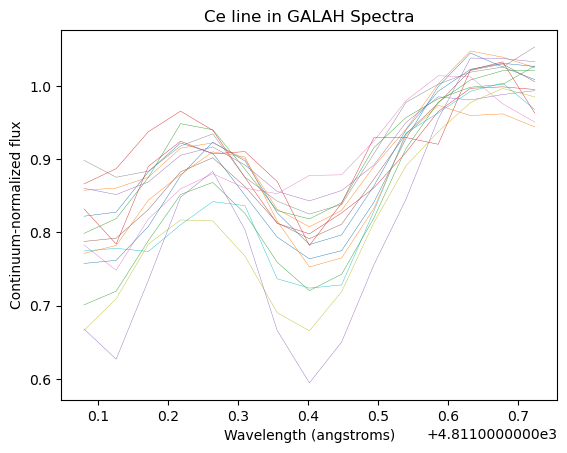

In [14]:
ce_line = (galah_wave_grid < 4811.34 + .4) & (galah_wave_grid > 4811.34 - .3)

plt.figure()
for i in range(15):
    plt.plot(galah_wave_grid[ce_line], gflux_clean_fin[i][ce_line], lw=.3)
    
plt.title("Ce line in GALAH Spectra")
plt.xlabel("Wavelength (angstroms)")
plt.ylabel("Continuum-normalized flux")
plt.show()



pull out Ce line for all stars

In [15]:
ce_line_all = gflux_clean_fin[:, ce_line] #this is your array of labels
ce_line_all.shape 

(16691, 15)

divide into train and test

In [16]:
mask = np.random.uniform(0,1,len(apid_clean_fin))
train = np.where(mask < .9)
test = np.where(mask  > .9)
len(train[0]), len(test[0])

(15026, 1665)

In [17]:
train_data = apflux_clean_fin[train]
train_labels = ce_line_all[train]

test_data = apflux_clean_fin[test]
test_labels = ce_line_all[test]

train_data.shape, train_labels.shape, test_data.shape, test_labels.shape, 

((15026, 7420), (15026, 15), (1665, 7420), (1665, 15))

Train/test below